# Phase 1: Local Model Development & Prototyping

**Goal:** Build and validate a functional bird species identification model on local machine.

1.  **Select & Prepare Dataset:** Manually downloading and loading the CUB-200-2011 dataset.
2.  **Train the Model:** Training a PyTorch CNN model using transfer learning.
3.  **Create an Inference Script:** Testing the trained model on a single image.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models, datasets
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import tarfile
import requests
from tqdm import tqdm

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
def download_and_extract_archive(url, download_root, extract_root=None, filename=None):
    """
    Downloads and extracts an archive file (e.g., .tgz).
    """
    if extract_root is None:
        extract_root = download_root
    if not filename:
        filename = os.path.basename(url)

    archive_path = os.path.join(download_root, filename)

    if not os.path.exists(extract_root):
        os.makedirs(extract_root)

    # Check if the extracted folder already exists
    # A bit of a heuristic: check for a common folder inside the archive
    if os.path.exists(os.path.join(extract_root, 'CUB_200_2011')):
        print("Dataset already extracted.")
        return

    # Download the file if it doesn't exist
    if not os.path.exists(archive_path):
        print(f"Downloading {url} to {archive_path}")
        response = requests.get(url, stream=True)
        response.raise_for_status()

        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kibibyte

        with open(archive_path, 'wb') as f, tqdm(
            desc=filename,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(block_size):
                bar.update(len(data))
                f.write(data)
        print("Download complete.")
    else:
        print("Archive file already exists.")

    # Extract the file
    print(f"Extracting {archive_path} to {extract_root}...")
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=extract_root)
    print("Extraction complete.")


In [ ]:
# Define image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define the data directory and download URL
DATA_DIR = '../data'
DATASET_URL = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz'

# Download and extract the data
download_and_extract_archive(DATASET_URL, DATA_DIR)

# The images are inside 'CUB_200_2011/images' directory, sorted by class
image_dir = os.path.join(DATA_DIR, 'CUB_200_2011', 'images')

# FIX: Load the dataset using ImageFolder with NO initial transform.
# This ensures it always returns PIL Images.
full_dataset = datasets.ImageFolder(root=image_dir, transform=None)

# Get class names
class_names = full_dataset.classes
num_classes = len(class_names)

print("\n--- Dataset Summary ---")
print(f"Total images: {len(full_dataset)}")
print(f"Total species: {num_classes}")
print("\nExample species names:")
print(class_names[:5])

CUB_200_2011.tgz: 100%|██████████| 1.07G/1.07G [01:03<00:00, 18.2MiB/s]


Download complete.
Extracting data/CUB_200_2011.tgz to data...
Extraction complete.

--- Dataset Summary ---
Total images: 11788
Total species: 200

Example species names:
['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet']


In [10]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# FIX: Create a wrapper class to apply the correct transforms to each subset.
# This works because the underlying dataset now returns PIL images.
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Apply the correct transforms to each new dataset
train_dataset = TransformedSubset(train_subset, transform=data_transforms['train'])
val_dataset = TransformedSubset(val_subset, transform=data_transforms['val'])

print(f"\nTraining set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create DataLoaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
}
print("\nDataLoaders created successfully.")


Training set size: 9430
Validation set size: 2358

DataLoaders created successfully.


In [11]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pre-trained ResNet-18 model
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the classifier
num_ftrs = model.fc.in_features

# Replace the last fully connected layer with a new one for our number of classes
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the selected device
model = model.to(device)

print("\nModel setup complete.")
print(model.fc) # Print the new final layer

Using device: cuda:0

Model setup complete.
Linear(in_features=512, out_features=200, bias=True)


In [18]:
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            dataset_size = len(dataloaders[phase].dataset)

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Start training
model = train_model(model, criterion, optimizer, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.6705 Acc: 0.6311
val Loss: 1.4358 Acc: 0.6522
Epoch 2/15
----------
train Loss: 1.6322 Acc: 0.6445
val Loss: 1.4232 Acc: 0.6455
Epoch 3/15
----------
train Loss: 1.6485 Acc: 0.6385
val Loss: 1.4081 Acc: 0.6531
Epoch 4/15
----------
train Loss: 1.6159 Acc: 0.6460
val Loss: 1.3966 Acc: 0.6527
Epoch 5/15
----------
train Loss: 1.5869 Acc: 0.6505
val Loss: 1.3807 Acc: 0.6628
Epoch 6/15
----------
train Loss: 1.6172 Acc: 0.6427
val Loss: 1.3877 Acc: 0.6514
Epoch 7/15
----------
train Loss: 1.5849 Acc: 0.6435
val Loss: 1.3766 Acc: 0.6552
Epoch 8/15
----------
train Loss: 1.5845 Acc: 0.6474
val Loss: 1.3752 Acc: 0.6522
Epoch 9/15
----------
train Loss: 1.5757 Acc: 0.6461
val Loss: 1.3560 Acc: 0.6624
Epoch 10/15
----------
train Loss: 1.5708 Acc: 0.6537
val Loss: 1.3629 Acc: 0.6556
Epoch 11/15
----------
train Loss: 1.5408 Acc: 0.6558
val Loss: 1.3405 Acc: 0.6658
Epoch 12/15
----------
train Loss: 1.5159 Acc: 0.6552
val Loss: 1.3494 Acc: 0.6561
Epoch 13/15
-

In [ ]:
MODEL_PATH = '../models/species_identifier_model.pth'
torch.save(model.state_dict(), MODEL_PATH)

print(f"\nModel saved to {MODEL_PATH}")


Model saved to species_identifier_model.pth



--- Inference Test ---
Image Path: data/CUB_200_2011/images/188.Pileated_Woodpecker/Pileated_Woodpecker_0106_180446.jpg


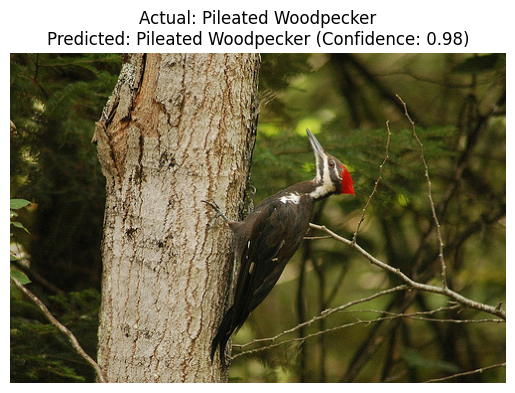

Actual species: Pileated Woodpecker
Predicted species: Pileated Woodpecker with confidence 0.98


In [23]:
def predict_image(image_path, model, device, class_names_map):
    model.eval() # Set model to evaluation mode

    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    image_transform = data_transforms['val'] # Use validation transforms
    image = image_transform(image).unsqueeze(0)
    image = image.to(device)

    # Make a prediction
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    # Get the species name
    predicted_species = class_names_map[predicted_idx.item()]

    return predicted_species, confidence.item()

# --- Test the inference function ---
# 1. Load the model from the saved file
inference_model = models.resnet18()
num_ftrs = inference_model.fc.in_features
inference_model.fc = nn.Linear(num_ftrs, num_classes)
inference_model.load_state_dict(torch.load(MODEL_PATH))
inference_model = inference_model.to(device)

# 2. Get a sample image path and its true label
if len(val_dataset) > 0:
    # Get the path and true label from the validation subset
    sample_image_path, true_label_idx = val_dataset.subset.dataset.samples[val_dataset.subset.indices[15]]
    actual_species = class_names[true_label_idx]

    # 3. Make a prediction
    predicted_species, confidence = predict_image(sample_image_path, inference_model, device, class_names)

    # 4. Show the result
    print(f"\n--- Inference Test ---")
    print(f"Image Path: {sample_image_path}")
    image = Image.open(sample_image_path)
    plt.imshow(image)

    # Clean up species name for display
    display_actual = actual_species.split('.')[-1].replace('_', ' ')
    display_predicted = predicted_species.split('.')[-1].replace('_', ' ')
    title_text = f"Actual: {display_actual}\nPredicted: {display_predicted} (Confidence: {confidence:.2f})"
    plt.title(title_text)
    plt.axis('off')
    plt.show()

    print(f"Actual species: {display_actual}")
    print(f"Predicted species: {display_predicted} with confidence {confidence:.2f}")
else:
    print("\n--- Inference Test ---")
    print("Validation set is empty. Cannot perform inference test.")

